In [34]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os
import shutil

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud import ml
from tqdm import tqdm

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [5]:
with open("svc.pkl", "rb") as f:
    pipe = pickle.load(f)

with open("svc_type0.pkl", "rb") as f:
    pipe0 = pickle.load(f)

with open("svc_type1.pkl", "rb") as f:
    pipe1 = pickle.load(f)

In [38]:

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    # print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0:
            continue

        if job.isfile(df_path):
            # dataset = pl.read_parquet(job.fn(df_path))
            # output[sp].append(dataset)
            continue

        traj = gsd.hoomd.open(exper)
        oexper = exper.replace("traj-fire", "traj")
        otraj = gsd.hoomd.open(oexper)

        # print(len(traj))
        
        # print(max_shear, period, temp)

        softness = []
        frames = []
        types = []
        start = 1
        end = 81
        cycle_start_idx = lambda i: -1 + i*40
        for frame in tqdm(range(cycle_start_idx(start), cycle_start_idx(end), 40)):

            frames.append(frame)

            snap = traj[frame]

            typeids = snap.particles.typeid
            types.append(typeids)
            softb = np.zeros_like(typeids, dtype=np.float32)

            query_indices0 = np.arange(snap.particles.N)[typeids == 0]
            sfs0 = ml.compute_structure_functions_snap(snap, query_indices0)
            soft0 = pipe0.decision_function(sfs0)

            query_indices1 = np.arange(snap.particles.N)[typeids == 1]
            sfs1 = ml.compute_structure_functions_snap(snap, query_indices1)
            soft1 = pipe1.decision_function(sfs1)

            softb[typeids == 0] = soft0
            softb[typeids == 1] = soft1

            softness.append(softb)

        dataset = pl.DataFrame({"frame": frames, "id": np.array(types), "soft": np.array(softness)})
        # dataset = dataset.explode(["id", "soft"]).reset_index(drop=True)
        dataset.write_parquet(job.fn(df_path), use_pyarrow=True)
        # break
    # break


        
            

634e14bc75836df75158fb15f379d8bb


  0%|          | 0/80 [00:00<?, ?it/s]

100%|██████████| 80/80 [00:19<00:00,  4.19it/s]


7ec2f6aca035e69077eab24383a21cb6


100%|██████████| 80/80 [00:18<00:00,  4.41it/s]


cfa1e4c0007fd65d020f809715a6f0b4


100%|██████████| 80/80 [00:17<00:00,  4.53it/s]


ecce68c50e28a33684826f28780bf6e9


100%|██████████| 80/80 [00:18<00:00,  4.41it/s]


1d0fe2ba44a6f635f5504dcbcee0ebc9


 40%|████      | 32/80 [00:07<00:10,  4.58it/s]

In [ ]:

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    # print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0:
            continue

        if job.isfile(df_path):
            # dataset = pl.read_parquet(job.fn(df_path))
            # output[sp].append(dataset)
            continue

        traj = gsd.hoomd.open(exper)
        oexper = exper.replace("traj-fire", "traj")
        otraj = gsd.hoomd.open(oexper)

        # print(len(traj))
        
        # print(max_shear, period, temp)

        softness = []
        frames = []
        types = []
        start = 75
        end = 80
        cycle_start_idx = lambda i: -1 + i*40
        for frame in tqdm(range(cycle_start_idx(start), cycle_start_idx(end))):

            frames.append(frame)

            snap = traj[frame]

            typeids = snap.particles.typeid
            types.append(typeids)
            softb = np.zeros_like(typeids, dtype=np.float32)

            query_indices0 = np.arange(snap.particles.N)[typeids == 0]
            sfs0 = ml.compute_structure_functions_snap(snap, query_indices0)
            soft0 = pipe0.decision_function(sfs0)

            query_indices1 = np.arange(snap.particles.N)[typeids == 1]
            sfs1 = ml.compute_structure_functions_snap(snap, query_indices1)
            soft1 = pipe1.decision_function(sfs1)

            softb[typeids == 0] = soft0
            softb[typeids == 1] = soft1

            softness.append(softb)

        dataset = pl.DataFrame({"frame": frames, "id": np.array(types), "soft": np.array(softness)})
        # dataset = dataset.explode(["id", "soft"]).reset_index(drop=True)
        dataset.write_parquet(job.fn(df_path), use_pyarrow=True)
        # break
    # break


        
            

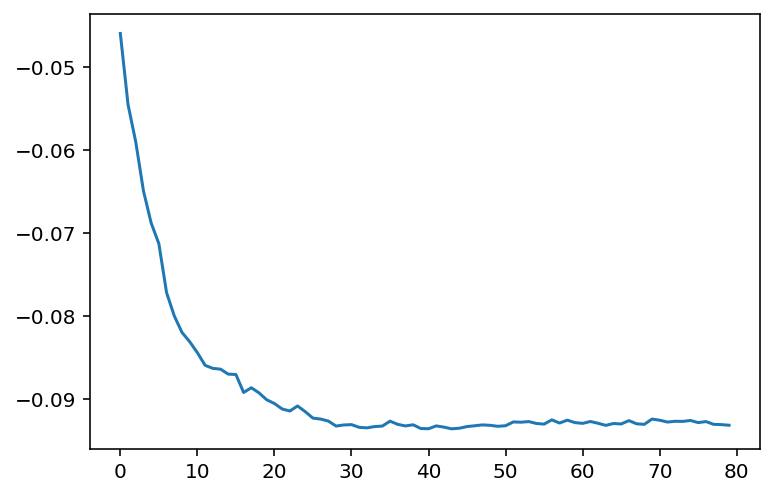

In [25]:
xs = []
ys = []
yerrs = []

for frame, _, softness in dataset.rows():
    xs.append(frame)
    ys.append(np.mean(softness))
    yerrs.append(np.std(softness))

xs = np.array(xs)
ys = np.array(ys)
yerrs = np.array(yerrs)

plt.plot(ys)

In [96]:
H, bins = np.histogram(softb, bins=100)

In [98]:
H2, _ = np.histogram(softb, bins=bins)

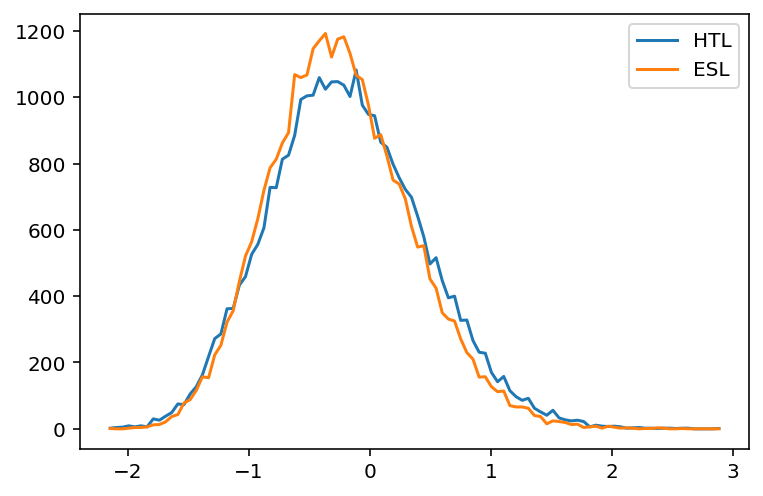

In [99]:
plt.plot(bins[:-1], H, label="HTL")
plt.plot(bins[:-1], H2, label="ESL")
plt.legend()

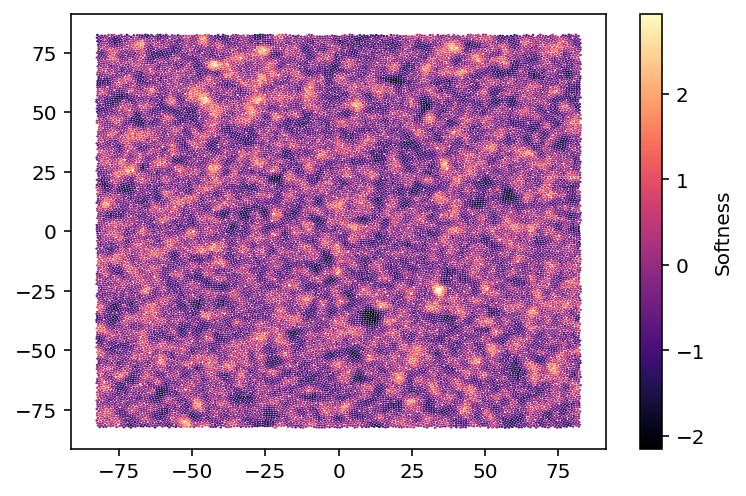

In [95]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# extract particle positions and data
positions = snap.particles.position
diams = snap.particles.diameter
color_data = softb

# create a list of circles with positions and radius
circles = [Circle((x[0], x[1]), radius=d/2.0) for x, d in zip(positions, diams)]

# create a patch collection with circles and color data
collection = PatchCollection(circles, cmap='magma')
collection.set_array(color_data)

# plot particles with color
fig, ax = plt.subplots()
ax.add_collection(collection)
ax.autoscale()

# zoom in 5x
# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# ax.set_xlim((xlim[0] + xlim[1])/2 - (xlim[1] - xlim[0])/10, (xlim[0] + xlim[1])/2 + (xlim[1] - xlim[0])/10)
# ax.set_ylim((ylim[0] + ylim[1])/2 - (ylim[1] - ylim[0])/10, (ylim[0] + ylim[1])/2 + (ylim[1] - ylim[0])/10)

plt.colorbar(collection, label="Softness")

plt.show()


In [91]:
norm = collection.norm

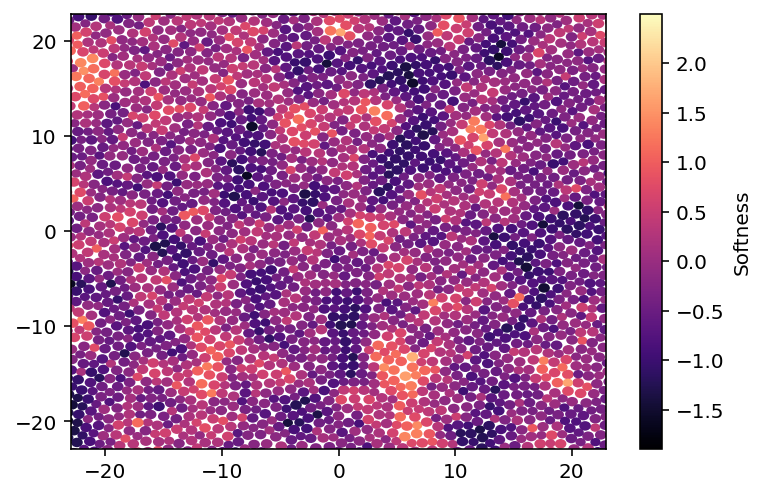

In [103]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# extract particle positions and data
positions = snap.particles.position
diams = snap.particles.diameter
color_data = softb

# create a list of circles with positions and radius
circles = [Circle((x[0], x[1]), radius=d/2.0) for x, d in zip(positions, diams)]

# create a patch collection with circles and color data
collection = PatchCollection(circles, cmap='magma', norm=norm)
collection.set_array(color_data)

# plot particles with color
fig, ax = plt.subplots()
ax.add_collection(collection)
ax.autoscale()

# zoom in 5x
zoom = 4
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim((xlim[0] + xlim[1])/2 - (xlim[1] - xlim[0])/zoom/2, (xlim[0] + xlim[1])/2 + (xlim[1] - xlim[0])/zoom/2)
ax.set_ylim((ylim[0] + ylim[1])/2 - (ylim[1] - ylim[0])/zoom/2, (ylim[0] + ylim[1])/2 + (ylim[1] - ylim[0])/zoom/2)

plt.colorbar(collection, label="Softness")

plt.show()
